In [161]:
import pandas as pd
df = pd.read_csv(
    "ITSM project data set list.csv",
    delimiter=';',
    encoding='utf-8',
    quotechar='"',
    dtype={'Urgency': 'str'},  # read as string
    low_memory=False           # helps avoid chunk loading issues
)

In [163]:
df.head()

,CI_Name,CI_Cat,CI_Subcat,WBS,Incident_ID,Status,Impact,Urgency,Priority,number_cnt,...,Reopen_Time,Resolved_Time,Close_Time,Handle_Time_hrs,Closure_Code,No_of_Related_Interactions,Related_Interaction,No_of_Related_Incidents,No_of_Related_Changes,Related_Change
0,SUB000508,subapplication,Web Based Application,WBS000162,IM0000004,Closed,4,4,4.0,0.601292,...,NaN,04-11-2013 13:50,04-11-2013 13:51,"3,87,16,91,111",Other,1.0,SD0000007,2.0,NaN,NaN
1,WBA000124,application,Web Based Application,WBS000088,IM0000005,Closed,3,3,3.0,0.415050,...,02-12-2013 12:31,02-12-2013 12:36,02-12-2013 12:36,"4,35,47,86,389",Software,1.0,SD0000011,1.0,NaN,NaN
2,DTA000024,application,Desktop Application,WBS000092,IM0000006,Closed,NS,3,NaN,0.517551,...,NaN,13-01-2014 15:12,13-01-2014 15:13,"4,84,31,19,444",No error - works as designed,1.0,SD0000017,NaN,NaN,NaN
3,WBA000124,application,Web Based Application,WBS000088,IM0000011,Closed,4,4,4.0,0.642927,...,NaN,14-11-2013 09:31,14-11-2013 09:31,"4,32,18,33,333",Operator error,1.0,SD0000025,NaN,NaN,NaN
4,WBA000124,application,Web Based Application,WBS000088,IM0000012,Closed,4,4,4.0,0.345258,...,NaN,08-11-2013 13:55,08-11-2013 13:55,"3,38,39,03,333",Other,1.0,SD0000029,NaN,NaN,NaN


In [165]:
date_cols = ['Open_Time', 'Reopen_Time', 'Resolved_Time', 'Close_Time']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

In [166]:
numeric_cols = ['Impact', 'Urgency', 'Priority']
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # Converts 'NS', 'NA' → NaN

In [167]:
df.drop(columns=['Handle_Time_hrs'], inplace=True)

In [168]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46606 entries, 0 to 46605
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   CI_Name                     46606 non-null  object        
 1   CI_Cat                      46495 non-null  object        
 2   CI_Subcat                   46495 non-null  object        
 3   WBS                         46606 non-null  object        
 4   Incident_ID                 46606 non-null  object        
 5   Status                      46606 non-null  object        
 6   Impact                      45226 non-null  float64       
 7   Urgency                     46605 non-null  float64       
 8   Priority                    45226 non-null  float64       
 9   number_cnt                  46606 non-null  float64       
 10  Category                    46606 non-null  object        
 11  KB_number                   46606 non-null  object    

Related_Change                46046
No_of_Related_Changes         46046
No_of_Related_Incidents       45384
Reopen_Time                   44322
Resolved_Time                  1780
Impact                         1380
Priority                       1380
Closure_Code                    460
No_of_Related_Interactions      114
CI_Subcat                       111
CI_Cat                          111
Urgency                           1
No_of_Reassignments               1
Related_Interaction               0
Close_Time                        0
CI_Name                           0
Open_Time                         0
KB_number                         0
Category                          0
number_cnt                        0
Status                            0
Incident_ID                       0
WBS                               0
Alert_Status                      0
dtype: int64

In [169]:
# Fill categorical
df['CI_Cat'].fillna('Unknown', inplace=True)
df['CI_Subcat'].fillna('Unknown', inplace=True)
df['Closure_Code'].fillna('Unknown', inplace=True)

# Fill numeric
df['No_of_Related_Interactions'].fillna(0, inplace=True)
df['No_of_Reassignments'].fillna(0, inplace=True)

# Drop rows where key ML features are missing
df.dropna(subset=['Impact', 'Urgency', 'Priority'], inplace=True)

In [170]:
df.drop(columns=[
    'Reopen_Time', 'No_of_Related_Incidents',
    'No_of_Related_Changes', 'Related_Change'
], inplace=True)

In [177]:
# Extract time features
df['Open_Year'] = df['Open_Time'].dt.year
df['Open_Month'] = df['Open_Time'].dt.month
df['Resolution_Days'] = (df['Resolved_Time'] - df['Open_Time']).dt.days
df['Response_Hours'] = (df['Resolved_Time'] - df['Open_Time']).dt.total_seconds() / 3600

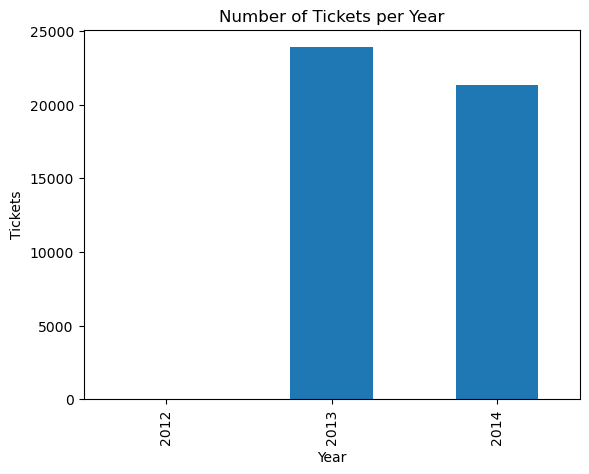

In [179]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tickets by Year
df['Open_Year'].value_counts().sort_index().plot(kind='bar')
plt.title("Number of Tickets per Year")
plt.xlabel("Year")
plt.ylabel("Tickets")
plt.show()

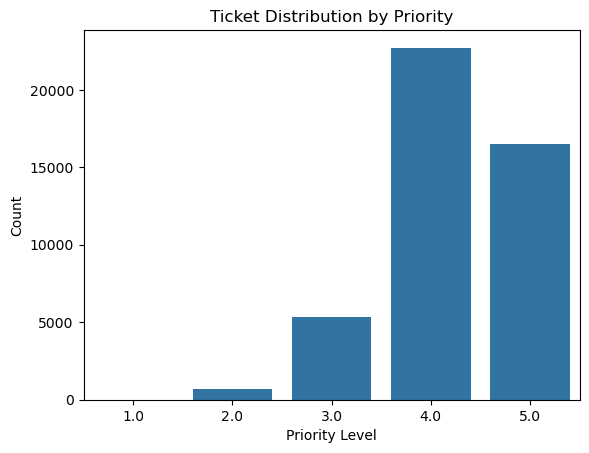

In [181]:
sns.countplot(data=df, x='Priority')
plt.title("Ticket Distribution by Priority")
plt.xlabel("Priority Level")
plt.ylabel("Count")
plt.show()

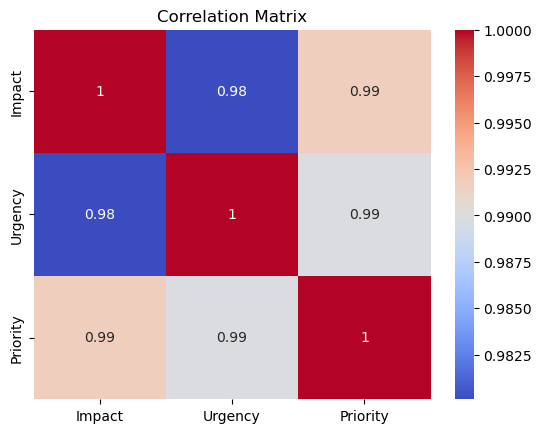

In [183]:
sns.heatmap(df[['Impact', 'Urgency', 'Priority']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

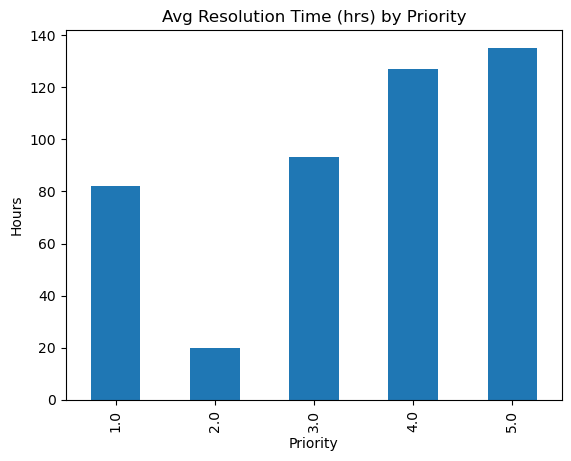

In [185]:
df.groupby('Priority')['Response_Hours'].mean().plot(kind='bar')
plt.title("Avg Resolution Time (hrs) by Priority")
plt.ylabel("Hours")
plt.show()

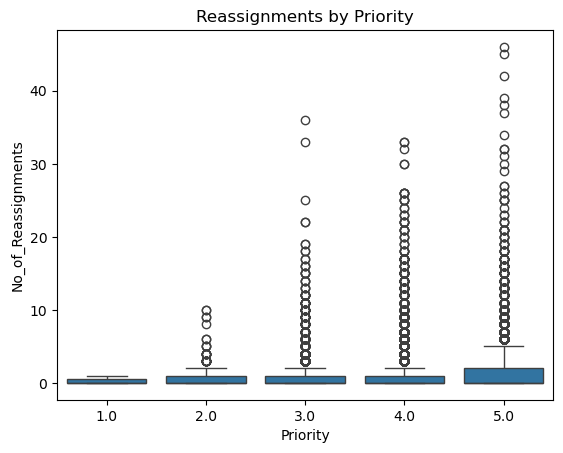

In [187]:
sns.boxplot(data=df, x='Priority', y='No_of_Reassignments')
plt.title("Reassignments by Priority")
plt.show()

In [189]:
df['High_Priority'] = df['Priority'].apply(lambda x: 1 if x in [1, 2] else 0)

In [191]:
from sklearn.model_selection import train_test_split

# You can include more features later like 'CI_Cat', 'CI_Subcat' (after encoding)
features = ['Impact', 'Urgency', 'No_of_Reassignments']
X = df[features]
y = df['High_Priority']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [193]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8908
           1       1.00      1.00      1.00       137

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



In [195]:
y.value_counts(normalize=True)

0    0.984522
1    0.015478
Name: High_Priority, dtype: float64

In [197]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(model, X, y, cv=5, scoring='f1')
print("Cross-validated F1 scores:", scores)

Cross-validated F1 scores: [1. 1. 1. 1. 1.]


In [198]:
# Ensure Open_Time is datetime
df['Open_Time'] = pd.to_datetime(df['Open_Time'], errors='coerce')

# Group by month
monthly_tickets = df.groupby(df['Open_Time'].dt.to_period("M")).size()
monthly_tickets = monthly_tickets.to_timestamp()  # Convert Period to Timestamp
monthly_tickets.name = "Ticket_Count"

print(monthly_tickets.head())

Open_Time
2012-02-01    1
2012-03-01    1
2012-07-01    1
2012-08-01    4
2012-09-01    2
Name: Ticket_Count, dtype: int64


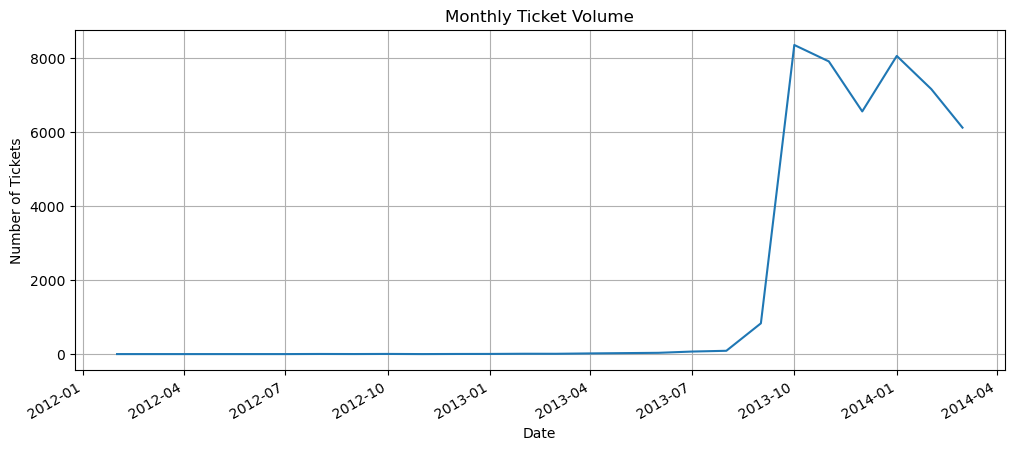

In [201]:
import matplotlib.pyplot as plt
monthly_tickets.plot(figsize=(12, 5))
plt.title("Monthly Ticket Volume")
plt.xlabel("Date")
plt.ylabel("Number of Tickets")
plt.grid(True)
plt.show()

In [203]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [204]:
from prophet import Prophet
ticket_df = monthly_tickets.reset_index()
ticket_df.columns = ['ds', 'y']

In [207]:
pip install ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [209]:
model = Prophet()
model.fit(ticket_df)

13:38:02 - cmdstanpy - INFO - Chain [1] start processing
13:38:02 - cmdstanpy - INFO - Chain [1] done processing


In [211]:
# Forecast for next 12 months
future = model.make_future_dataframe(periods=12, freq='M')
forecast = model.predict(future)

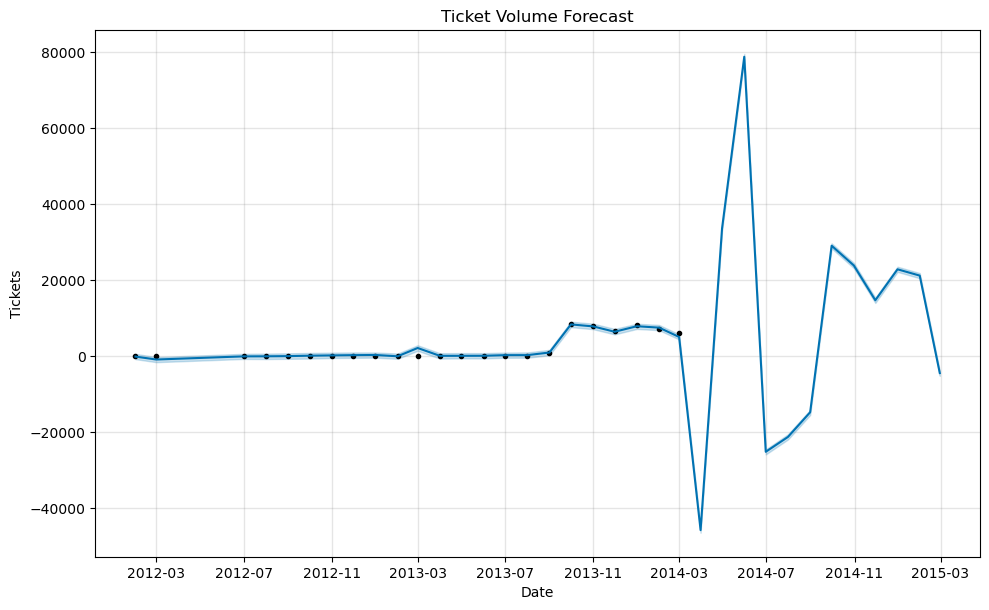

In [213]:
fig = model.plot(forecast)
plt.title("Ticket Volume Forecast")
plt.xlabel("Date")
plt.ylabel("Tickets")
plt.show()

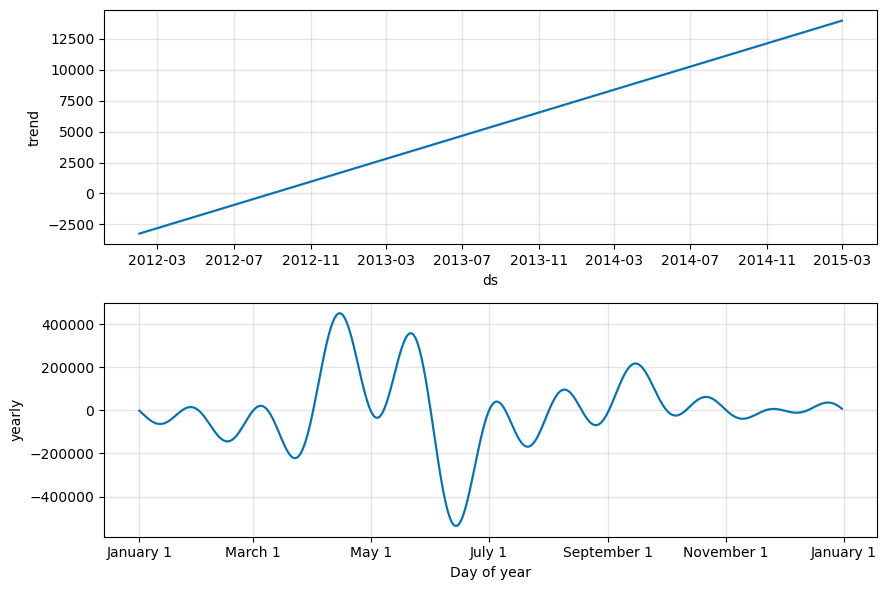

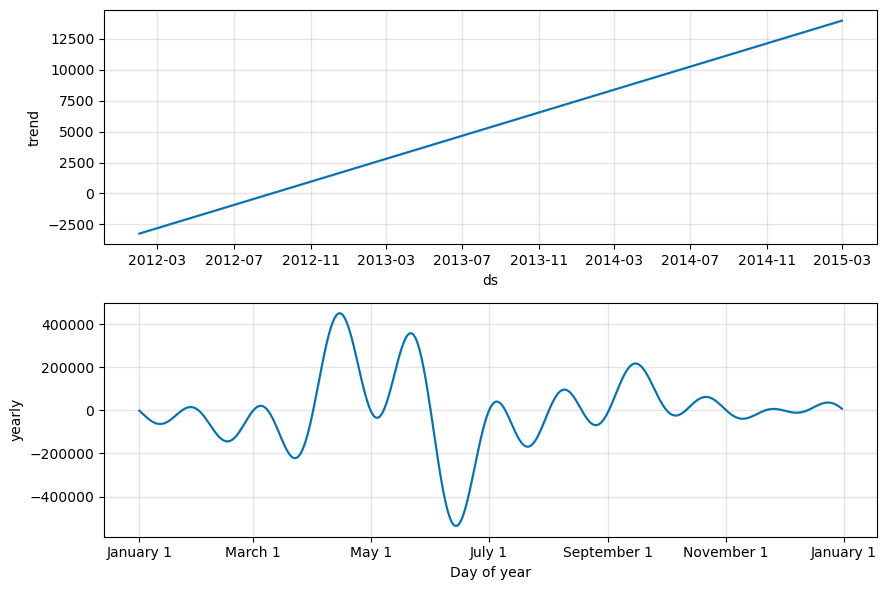

In [215]:
model.plot_components(forecast)

In [217]:
df['Priority'].value_counts().sort_index()

1.0        3
2.0      697
3.0     5323
4.0    22717
5.0    16485
Name: Priority, dtype: int64

In [219]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)

In [221]:
features = ['Impact', 'Urgency', 'No_of_Reassignments', 'Open_Year', 'Open_Month']
target = 'Priority'

In [223]:
df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

In [225]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [229]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
df_model = df_model[df_model['Priority'] != 1.0]

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       1.00      1.00      1.00         1
         2.0       1.00      1.00      1.00       136
         3.0       1.00      1.00      1.00      1073
         4.0       1.00      1.00      1.00      4502
         5.0       1.00      1.00      1.00      3333

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



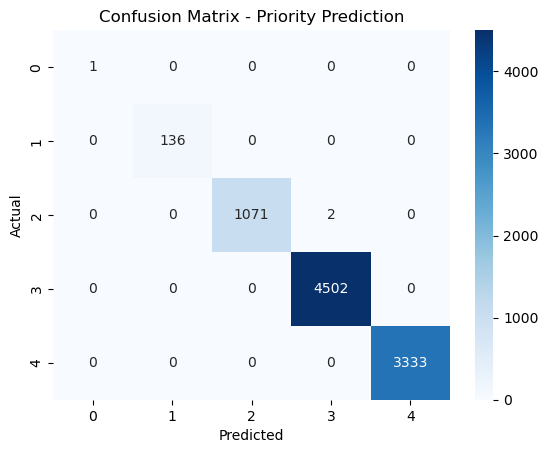

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Priority Prediction")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [233]:
df['CI_Cat'].value_counts()

application             31876
subapplication           7720
computer                 3544
storage                   653
hardware                  406
software                  294
displaydevice             212
database                  168
officeelectronics         139
Unknown                   108
networkcomponents          99
applicationcomponent        4
Phone                       2
Name: CI_Cat, dtype: int64

In [235]:
cat_counts = df['CI_Cat'].value_counts()
rare_cats = cat_counts[cat_counts < 300].index

df['CI_Cat_Grouped'] = df['CI_Cat'].apply(lambda x: 'Other' if x in rare_cats else x)

In [237]:
df['Day_of_Week'] = df['Open_Time'].dt.dayofweek
df['Hour'] = df['Open_Time'].dt.hour

In [239]:
from sklearn.preprocessing import LabelEncoder

# Encode CI_Cat_Grouped (target)
le_target = LabelEncoder()
df['CI_Cat_Grouped_Encoded'] = le_target.fit_transform(df['CI_Cat_Grouped'])

# Encode categorical features
cat_cols = ['Category', 'Closure_Code', 'Alert_Status']
label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    df[col] = df[col].astype(str)  # Ensure all are strings
    df[col + '_Encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le

In [241]:
features = [
    'Impact', 'Urgency', 'No_of_Reassignments',
    'Open_Year', 'Open_Month', 'Day_of_Week', 'Hour',
    'Category_Encoded', 'Closure_Code_Encoded', 'Alert_Status_Encoded'
]
target = 'CI_Cat_Grouped_Encoded'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

In [243]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.12      0.20      0.15       199
           1       0.80      0.70      0.75      6348
           2       0.51      0.55      0.53       728
           3       0.25      0.33      0.29        90
           4       0.11      0.39      0.18       135
           5       0.35      0.42      0.38      1545

    accuracy                           0.62      9045
   macro avg       0.36      0.43      0.38      9045
weighted avg       0.67      0.62      0.64      9045



In [244]:
print(df.columns.tolist())

['CI_Name', 'CI_Cat', 'CI_Subcat', 'WBS', 'Incident_ID', 'Status', 'Impact', 'Urgency', 'Priority', 'number_cnt', 'Category', 'KB_number', 'Alert_Status', 'No_of_Reassignments', 'Open_Time', 'Resolved_Time', 'Close_Time', 'Closure_Code', 'No_of_Related_Interactions', 'Related_Interaction', 'Open_Year', 'Open_Month', 'Resolution_Days', 'Response_Hours', 'High_Priority', 'CI_Cat_Grouped', 'Day_of_Week', 'Hour', 'CI_Cat_Grouped_Encoded', 'Category_Encoded', 'Closure_Code_Encoded', 'Alert_Status_Encoded']


In [247]:
# Convert to lowercase for text search
df['Closure_Code'] = df['Closure_Code'].astype(str).str.lower()

# Define failure keywords
failure_keywords = ['fail', 'error', 'misconfig', 'rollback']

# Create target column
df['Ticket_Failed'] = df['Closure_Code'].apply(
    lambda x: 1 if any(keyword in x for keyword in failure_keywords) else 0
)
# Check the class balance
print(df['Ticket_Failed'].value_counts())

0    36979
1     8246
Name: Ticket_Failed, dtype: int64


In [249]:
features = [
    'Impact', 'Urgency', 'No_of_Reassignments',
    'Open_Year', 'Open_Month', 'Day_of_Week', 'Hour',
    'Category_Encoded', 'Closure_Code_Encoded', 'Alert_Status_Encoded'
]
target = 'Ticket_Failed'

df_model = df[features + [target]].dropna()
X = df_model[features]
y = df_model[target]

In [251]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7396
           1       1.00      1.00      1.00      1649

    accuracy                           1.00      9045
   macro avg       1.00      1.00      1.00      9045
weighted avg       1.00      1.00      1.00      9045



In [253]:
df['Ticket_Failed'].value_counts(normalize=True)

0    0.817667
1    0.182333
Name: Ticket_Failed, dtype: float64

***ITSM Ticket Analytics Project***

***Project Summary:***

***Machine Learning Models Used in the ITSM Project***

***Conclusion:***